[nltk_data] Downloading package cmudict to /root/nltk_data...
[nltk_data]   Package cmudict is already up-to-date!
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


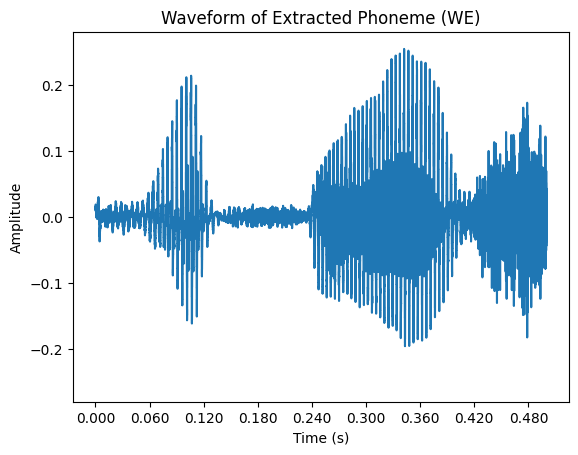

Recognized Text: THE RECOMMENDATIONS WE HAVE HERE SUGGESTED WOULD GREATLY ADVANCE THE SECURITY OF THE OFFICE WITHOUT ANY EMPAIRMENT OF OUR FUNDAMENTAL LIBERTIES
Recognized Phonemes:
  THE: [['DH', 'AH0'], ['DH', 'AH1'], ['DH', 'IY0']]
  RECOMMENDATIONS: [['R', 'EH2', 'K', 'AH0', 'M', 'AH0', 'N', 'D', 'EY1', 'SH', 'AH0', 'N', 'Z']]
  WE: [['W', 'IY1']]
  HAVE: [['HH', 'AE1', 'V']]
  HERE: [['HH', 'IY1', 'R']]
  SUGGESTED: [['S', 'AH0', 'G', 'JH', 'EH1', 'S', 'T', 'AH0', 'D'], ['S', 'AH0', 'G', 'JH', 'EH1', 'S', 'T', 'IH0', 'D']]
  WOULD: [['W', 'UH1', 'D']]
  GREATLY: [['G', 'R', 'EY1', 'T', 'L', 'IY0']]
  ADVANCE: [['AH0', 'D', 'V', 'AE1', 'N', 'S']]
  THE: [['DH', 'AH0'], ['DH', 'AH1'], ['DH', 'IY0']]
  SECURITY: [['S', 'IH0', 'K', 'Y', 'UH1', 'R', 'AH0', 'T', 'IY0']]
  OF: [['AH1', 'V'], ['AH0', 'V']]
  THE: [['DH', 'AH0'], ['DH', 'AH1'], ['DH', 'IY0']]
  OFFICE: [['AO1', 'F', 'AH0', 'S']]
  WITHOUT: [['W', 'IH0', 'TH', 'AW1', 'T'], ['W', 'IH0', 'DH', 'AW1', 'T']]
  ANY: [['EH1', 'N'

In [16]:
import torchaudio
import torch
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor
import librosa.display
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import cmudict

# Load CMU Pronouncing Dictionary
nltk.download('cmudict')
phoneme_dict = cmudict.dict()

def get_phonemes(word):
    word = word.lower()
    return phoneme_dict.get(word, ["UNKNOWN"])

# Load and preprocess the speech signal
def load_audio(file_path):
    waveform, sr = torchaudio.load(file_path)
    waveform = torchaudio.transforms.Resample(orig_freq=sr, new_freq=16000)(waveform)
    return waveform, waveform.squeeze().numpy(), 16000

# Load pre-trained model
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")

# Recognize phonemes
def recognize_phonemes(audio):
    inputs = processor(audio, return_tensors="pt", sampling_rate=16000).input_values
    with torch.no_grad():
        logits = model(inputs).logits
    transcription = processor.batch_decode(torch.argmax(logits, dim=-1))[0]
    phoneme_transcription = [get_phonemes(word) for word in transcription.split()]
    return transcription, phoneme_transcription

# Extract and visualize phoneme
def plot_phoneme(waveform, audio, start, end, sr, transcription, phoneme_transcription):
    start_sample, end_sample = int(start * sr), int(end * sr)
    phoneme_segment = waveform[:, start_sample:end_sample]
    phoneme_array = phoneme_segment.numpy()
    samples = phoneme_array.flatten()

    total_samples = waveform.size(1)
    segment_ratio = start_sample / total_samples
    num_words = len(transcription.split())
    word_index = int(segment_ratio * num_words)
    aligned_word = transcription.split()[word_index] if num_words > 0 else ''
    aligned_phoneme = get_phonemes(aligned_word)

    plt.figure()
    librosa.display.waveshow(samples, sr=16000)
    plt.title(f"Waveform of Extracted Phoneme ({aligned_word})")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.show()

    print(f"Recognized Text: {transcription}")
    print("Recognized Phonemes:")
    for word, phoneme in zip(transcription.split(), phoneme_transcription):
        print(f"  {word}: {phoneme}")
    print(f"Aligned Word: {aligned_word}")
    print(f"Phonemes for '{aligned_word}': {aligned_phoneme}")

# Run experiment
file_path = "LJ050-0278.wav"
wav, audio, sr = load_audio(file_path)
transcription, phoneme_transcription = recognize_phonemes(audio)
plot_phoneme(wav, audio, 1.0, 1.5, sr, transcription, phoneme_transcription)


In [ ]:
!apt-get update && apt-get install espeak -y # Install espeak using apt-get